PyTorch, and by extension PyTorch-Geometric, has some standardized ways of handling data and datasets. We first need to make a torch `Data` object from our graphs, with graphein's conversion functions

In [1]:
import graphein
from graphein.ml import GraphFormatConvertor
graphein.verbose(enabled=False)
from src import dataloader
import torch

[03/02/24 18:47:27] WARNING  To use the Graphein submodule                                         ]8;id=569979;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=323154;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#45\45]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[03/02/24 18:47:28] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=696366;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=615467;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/visualisation.py#36\36]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=301658;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=844973;file:///scicore/home/schwede/skrinj0000/mambaforge/envs/leuven_course_env/lib/python3.8/site-packages/graphein/protein/meshes.py#30\30]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [2]:
columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "sasa"
]

convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)

In [3]:
graphein_graph, interface_labels = dataloader.load_graph("1A0G", "A")

In order to train our model, we need to map interface labels to node_ids. We are going to do that by creating torch geometric graph, where interface labels will be stored in data.y and node features will be stacked and stored in data.x 

In [4]:
def graphein_to_torch_graph(graphein_graph, interface_labels, convertor, 
                            node_attr_columns = ["amino_acid_one_hot", "meiler"]):
    """
    Converts a Graphein graph to a pytorch-geometric Data object.
    """
    data = convertor(graphein_graph)
    data_dict= data.to_dict()
    x_data = []
    for x in node_attr_columns:
        if data_dict[x].ndim == 1:  #if we want to include solvent accesible area, which is one-dimensional
            x_data.append(torch.atleast_2d(data_dict[x]).T)
        else:
            x_data.append(torch.atleast_2d(data_dict[x]))
    data.x = torch.hstack(x_data).float()
    data.pos = data.coords.float()
    data.y = torch.zeros(data.num_nodes)
    for i, node_id in enumerate(data.node_id):
        if node_id in interface_labels:
            data.y[i] = 1
    return data

In [5]:
torch_geometric_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor)

Let's see what we have in the data object of torch_geometric_graph.

In [6]:
torch_geometric_graph

Data(edge_index=[2, 2746], node_id=[280], chain_id=[280], residue_number=[280], coords=[280, 3], amino_acid_one_hot=[280, 20], meiler=[280, 7], sasa=[280], kind=[1373], num_nodes=280, x=[280, 27], pos=[280, 3], y=[280])

In [7]:
torch_geometric_graph.edge_index.T

tensor([[  0,  10],
        [  0,  21],
        [  0,  67],
        ...,
        [279, 207],
        [279, 222],
        [279, 273]])

In [8]:
torch_geometric_graph.node_id

['A:PHE:89',
 'A:GLU:56',
 'A:LYS:267',
 'A:THR:274',
 'A:LYS:260',
 'A:THR:43',
 'A:THR:246',
 'A:MET:41',
 'A:PRO:97',
 'A:ALA:211',
 'A:TYR:88',
 'A:LYS:108',
 'A:LYS:187',
 'A:HIS:194',
 'A:GLY:163',
 'A:TYR:2',
 'A:ASP:12',
 'A:GLU:20',
 'A:GLU:161',
 'A:ASN:80',
 'A:ARG:171',
 'A:GLU:32',
 'A:GLY:128',
 'A:GLU:46',
 'A:GLU:250',
 'A:ALA:131',
 'A:ILE:223',
 'A:ASN:38',
 'A:ASN:182',
 'A:CYS:212',
 'A:ILE:48',
 'A:GLN:71',
 'A:VAL:44',
 'A:VAL:129',
 'A:LEU:231',
 'A:GLU:235',
 'A:THR:239',
 'A:PHE:69',
 'A:LEU:150',
 'A:LYS:275',
 'A:PHE:42',
 'A:ARG:257',
 'A:LEU:154',
 'A:VAL:220',
 'A:VAL:261',
 'A:PRO:119',
 'A:TYR:24',
 'A:ILE:62',
 'A:LEU:147',
 'A:THR:3',
 'A:GLU:104',
 'A:ASP:49',
 'A:LEU:169',
 'A:ASN:197',
 'A:LYS:145',
 'A:ILE:204',
 'A:ASP:21',
 'A:LEU:280',
 'A:GLY:39',
 'A:VAL:10',
 'A:GLY:23',
 'A:VAL:209',
 'A:THR:61',
 'A:ALA:201',
 'A:LYS:127',
 'A:ASP:188',
 'A:GLN:8',
 'A:TYR:114',
 'A:GLY:94',
 'A:LEU:140',
 'A:GLY:27',
 'A:HIS:160',
 'A:VAL:34',
 'A:LYS:79',

In [9]:
torch_geometric_graph.kind

[{'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'peptide_bond'},
 {'peptide_bond'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distance_threshold'},
 {'distanc

Visualization of amino acid types across interface and non-interface residues.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

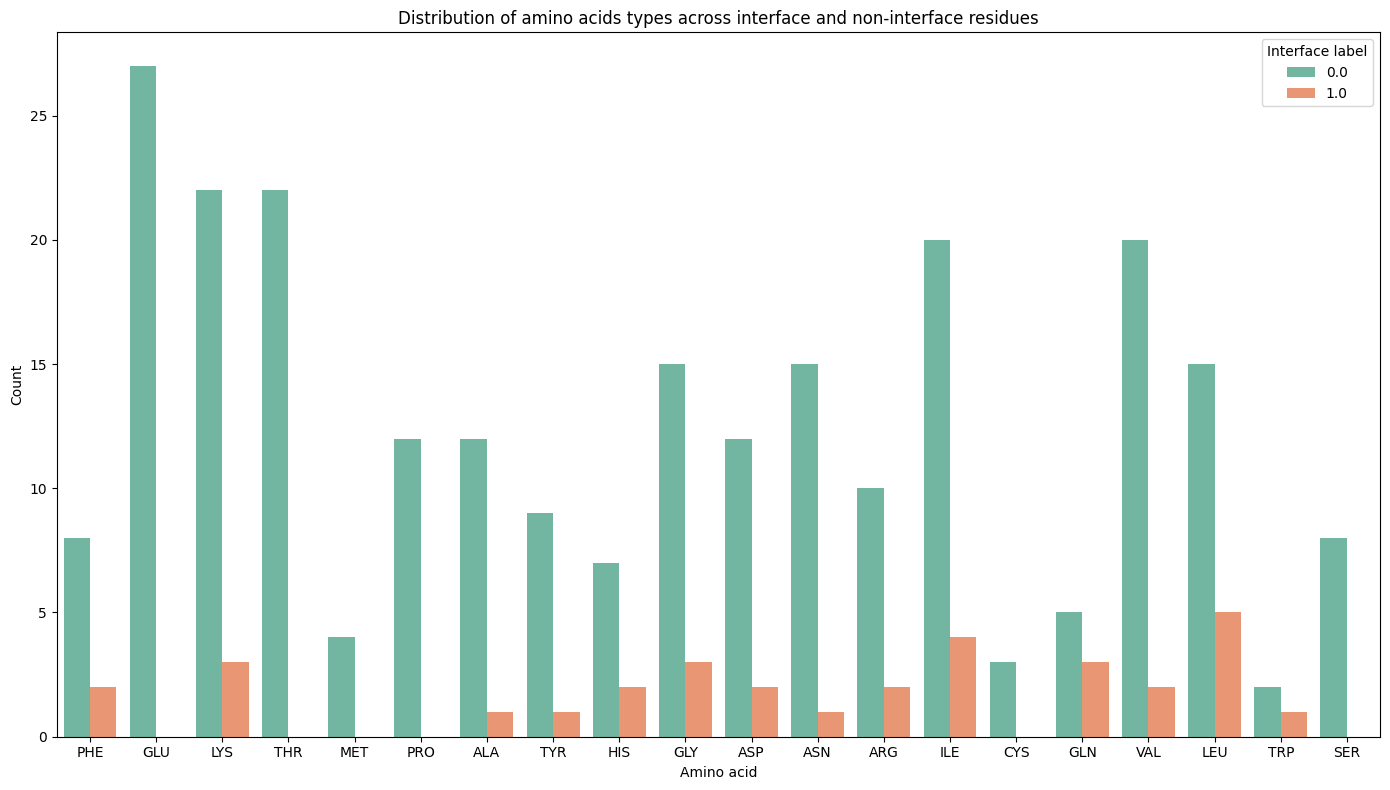

In [11]:
extracted_amino_acids = [s.split(":")[1] for s in torch_geometric_graph.node_id]

data_with_aa = {"amino acid": extracted_amino_acids, "interface labels": torch_geometric_graph.y}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

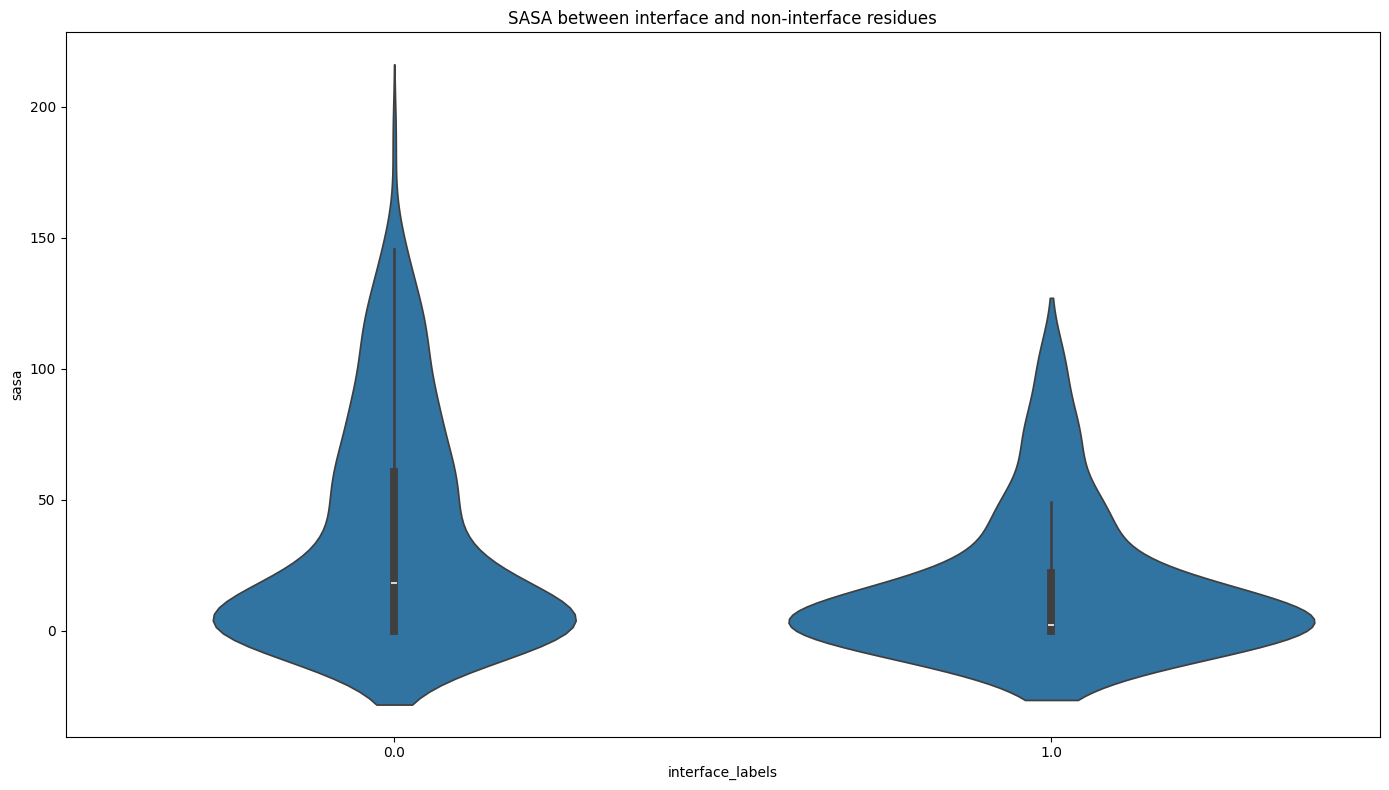

In [12]:
data = {
    "sasa": torch_geometric_graph.sasa,
    "interface_labels": torch_geometric_graph.y
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

## Creating a Dataset class

The `torch_geometric.data.Dataset` class is a standard way of representing a graph dataset in PyTorch. It is an abstract class that you can subclass to create your own dataset. Here's what the tyical architecture of a dataset looks like ([documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Dataset.html#torch_geometric.data.Dataset)):

- download(): function to download the dataset (in our case from `full_masif_site_dataset.txt`) and saves it in 'self.raw_dir' (in our case as a graphein graph and interface labels)
- process(): function to process the data from 'self.raw_dir' to pytorch geometric graph and saves it in 'self.processed_dir'
- property functions: raw_file_names, processed_file_names
  

In [13]:
from torch_geometric.data import Dataset
from pathlib import Path
import pickle
import torch

class ProteinDataset(Dataset):
    """
    torch-geometric Dataset class for loading protein files as graphs.
    """
    def __init__(self, root,
                 protein_names: list, 
                 pre_transform=None, 
                 transform=None):
        columns = [
            "chain_id",
            "coords",
            "edge_index",
            "kind",
            "node_id",
            "residue_number",
            "amino_acid_one_hot",
            "meiler",
            "sasa"
        ]
        self.convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg", columns=columns, verbose = None)
        self.protein_names = protein_names
        super(ProteinDataset, self).__init__(root, pre_transform=pre_transform, transform=transform)

    def download(self):
        for protein_name in self.protein_names:
            print(protein_name)
            output = Path(self.raw_dir) / f'{protein_name}.pkl'
            if not output.exists():
                try:
                    pdb_id, chain = protein_name.split("_")
                    graphein_graph, interface_labels = dataloader.load_graph(pdb_id, chain)
                    with open(output, "wb") as f:
                        pickle.dump((graphein_graph, interface_labels), f)
                except Exception as e:
                    print(f"Cannot load {protein_name} because of {e}")

    @property
    def raw_file_names(self):
        return [Path(self.raw_dir) / f"{protein_name}.pkl" for protein_name in self.protein_names if (Path(self.raw_dir) / f"{protein_name}.pt").exists()]

    @property
    def processed_file_names(self):
        return [Path(self.processed_dir) / f"{protein_name}.pt" for protein_name in self.protein_names if (Path(self.processed_dir) / f"{protein_name}.pt").exists()]

    def process(self):
        for protein_name in self.protein_names:
            output = Path(self.processed_dir) / f'{protein_name}.pt'
            if output.exists():
                continue
            raw = Path(self.raw_dir) / f"{protein_name}.pkl"
            if not raw.exists():
                continue
            with open(raw, "rb") as f:
                graphein_graph, interface_labels = pickle.load(f)
            torch_graph = graphein_to_torch_graph(graphein_graph, interface_labels, convertor=self.convertor)
            if self.pre_transform is not None:
                torch_graph = self.pre_transform(torch_graph)
            torch.save(torch_graph, output)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(self.processed_file_names[idx])
        return data


Let's run the code on our dataset!

In [14]:
#TODO: run the code on the first two hundred exmples in the dataset and explore the dataset. Do we see some patterns for interface and non-interface residues?

In [15]:
with open('full_masif_site_dataset.txt') as f:
    protein_names = [line.strip() for line in f]

dataset = ProteinDataset(root='./',
                         protein_names=protein_names[:100], 
                         pre_transform=None, 
                         transform=None)


1A0G_B
1A0H_D
1A22_A
1A2K_AB
Cannot load 1A2K_AB because of HTTP Error 404: Not Found
1A6J_B
1A79_C
1AA7_A
1ACB_I
1AIH_D
1ARZ_C
1AVA_C
1AVO_K
1AVO_L
1AY7_A
Cannot load 1AY7_A because of 97
1AZS_AB
1B0N_A
1B27_A
1B27_D
1B35_B
1B35_C
1B4U_C
1B65_D
1B6C_B
1B9L_D
1B9M_A
1B9Y_C
1BBH_A
1BC5_A
1BCP_H
1BCP_L
1BCR_A
1BCR_B
1BDF_D
1BIH_A
1BJA_A
1BO4_A
1BPL_A
1BVN_T
1BVP_2
1C3X_A
1C8N_C
1C8O_A
1C8U_B
1CGI_I
1CLI_A
1CMV_B
1CN4_B
1CQ3_B
1CQI_B
1D2Z_A
Cannot load 1D2Z_A because of 8
1D2Z_B
Cannot load 1D2Z_B because of 8
1D8H_A
1D9E_B
1DB2_A
1DBQ_B
1DBW_B
Cannot load 1DBW_B because of 24
1DHK_B
1DJ8_B
1DK4_A
1DLE_A
1DLT_A
1DM9_B
1DML_A
1DNW_B
1DPJ_A
1DQN_A
1DS8_L
1DXX_C
1E3U_A
1E44_A
1E4K_C
1E6E_B
1E96_B
1EAI_C
1EBO_F
1EER_A
1EEX_G
1EF1_D
1EFV_B
1EI1_B
1EK6_A
1EL6_A
1EM8_A
1EM8_B
1EMU_A
Cannot load 1EMU_A because of 75
1ETE_C
1EWJ_D
1EWY_C
1EXB_ABDC
1EZI_A
1EZU_AB
1F15_B
1F34_B
1F36_A
1F37_B
1F3M_B
1F3M_D
1F3R_B
1F3U_G
Cannot load 1F3U_G because of 655
1F3U_H
Cannot load 1F3U_H because of 655


Processing...
Done!


In [16]:
dataset[0]

Data(edge_index=[2, 2754], node_id=[282], chain_id=[282], residue_number=[282], coords=[282, 3], amino_acid_one_hot=[282, 20], meiler=[282, 7], sasa=[282], kind=[1377], num_nodes=282, x=[282, 27], pos=[282, 3], y=[282])

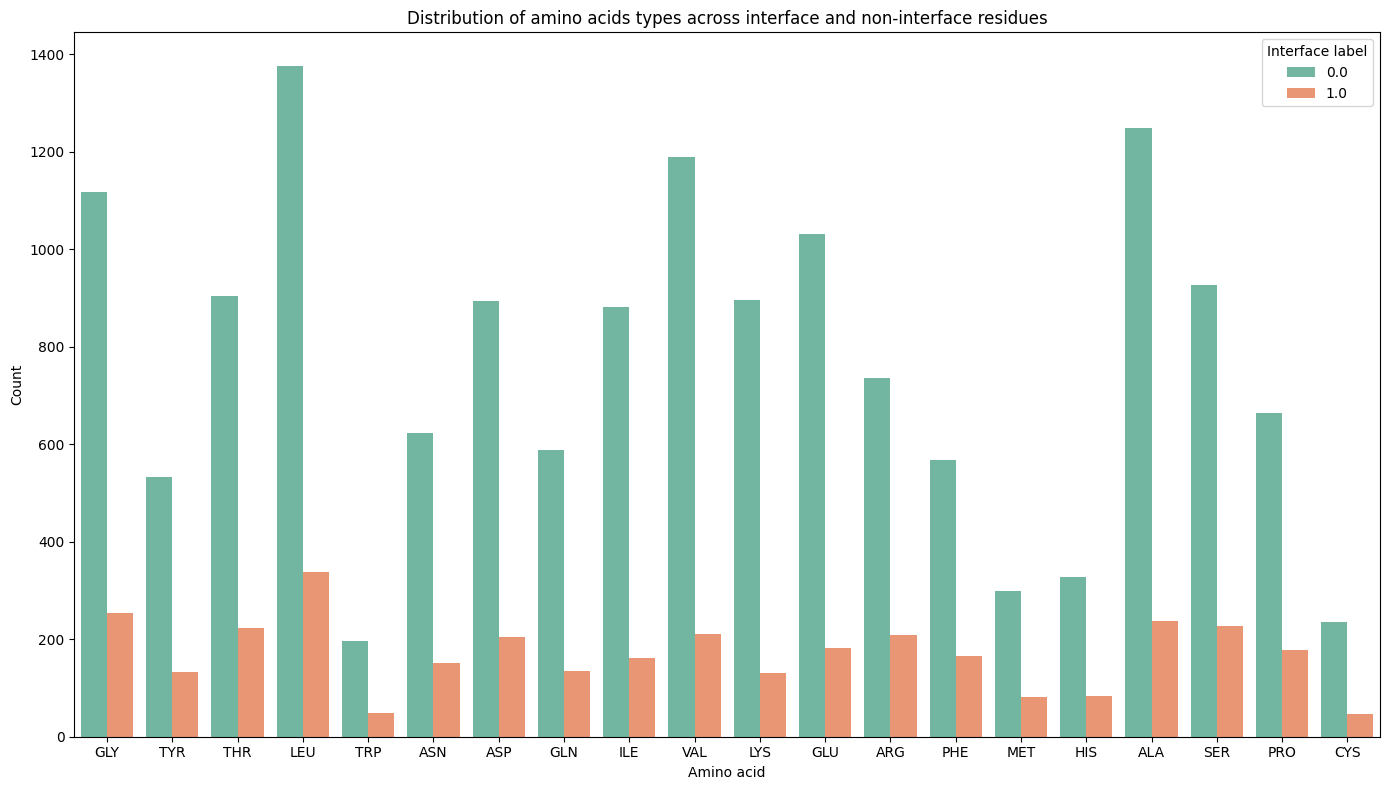

In [17]:
all_amino_acids = []
all_interface_labels = []

for torch_graph in dataset:
    extracted_amino_acids = [s.split(":")[1] for s in torch_graph.node_id]
    all_amino_acids.extend(extracted_amino_acids)
    all_interface_labels.extend(torch_graph.y.tolist())

data_with_aa = {
    "amino acid": all_amino_acids,
    "interface labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.countplot(x="amino acid", hue="interface labels", data=data_with_aa, palette="Set2")
plt.title("Distribution of amino acids types across interface and non-interface residues")
plt.ylabel("Count")
plt.xlabel("Amino acid")
plt.legend(title="Interface label", loc='upper right')
plt.tight_layout()
plt.show()

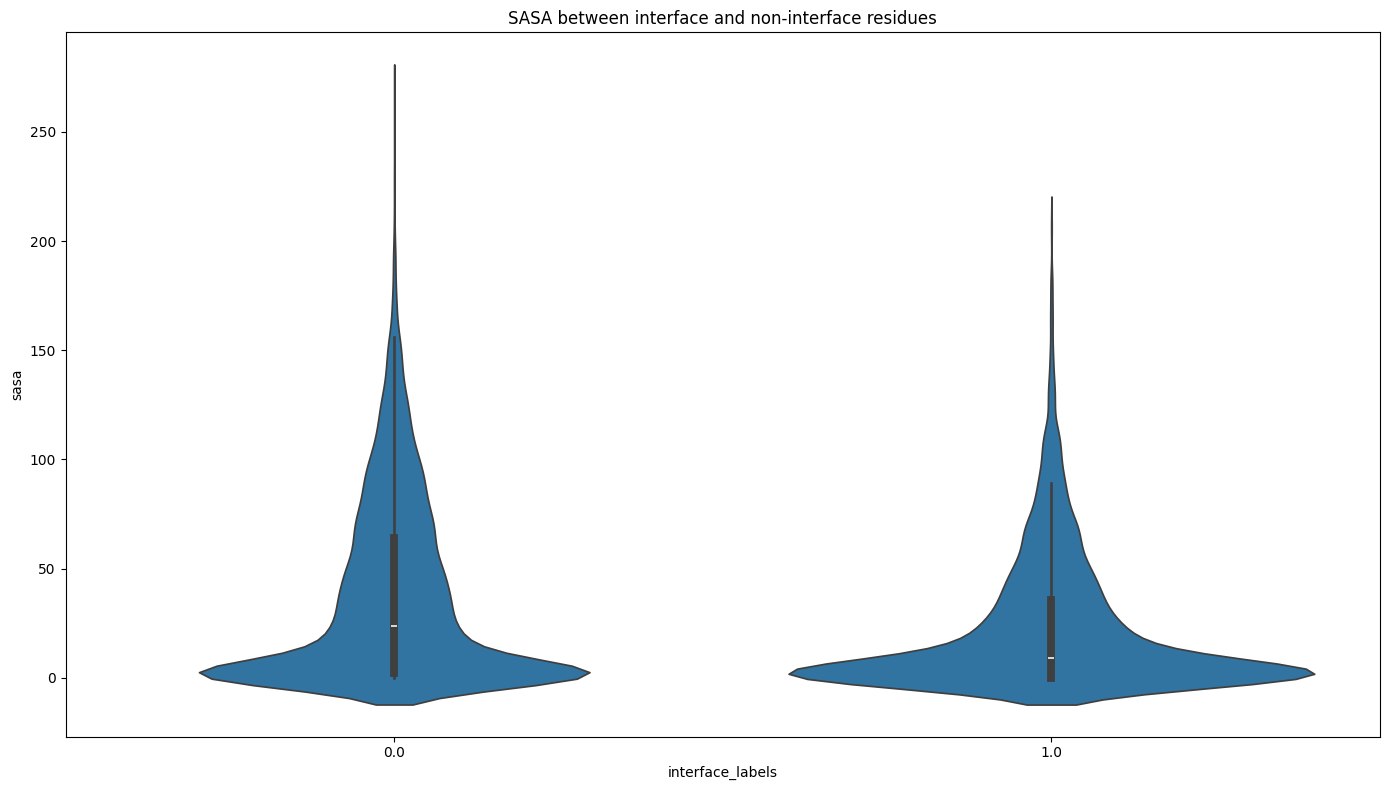

In [18]:
sasa = []
all_interface_labels = []

for torch_graph in dataset:
    sasa.extend(torch_graph.sasa.tolist())
    all_interface_labels.extend(torch_graph.y.tolist())

data = {
    "sasa": sasa,
    "interface_labels": all_interface_labels
}

plt.figure(figsize=(14, 8))
sns.violinplot(x="interface_labels", y="sasa", data=data)
plt.title("SASA between interface and non-interface residues")
plt.tight_layout()
plt.show()

In [19]:
# TODO: add functions to src/dataloader.py

This puts together what we've been implementing for loading proteins as graphs with graphein, converting those into PyTorch-geometric Data objects and then wrapping those into a PyTorch Dataset. 

Graphein also has a built-in `ProteinGraphDataset` class that combines these steps. It also has some nice features like (1) the ability to load a dataset of proteins from both the PDB or AlphaFold Database directory of PDB files, (2) the ability to apply custom transformations from your bioinformatics tools of choice to the PDB files (with the `pdb_transform` argument).

## Bonus
- pre-transforms and transforms
- how to use the `ProteinGraphDataset` class to include AlphaFold models